# Third Data Preparation Process

In this notebook file, selected data will be read from Raw Selected pkl file.

After that the faces in the images of the selected data will be detected.

Since face detection is a study in itself (See https://en.wikipedia.org/wiki/Face_detection),
this will be done in this project using the haarcascade_frontalface_alt2 xml file
(See https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html and
https://github.com/opencv/opencv/tree/master/data/haarcascades)
trained for face detection in the opencv library.

Also see https://en.wikipedia.org/wiki/Cascading_classifiers for details of Cascading Classifier

xml file to be used for face detection was added to <ins>/Cascade/</ins> folder.

This project will not focus on face detection. 
For this reason, the details of face detection will not be mentioned.

Images will be drawn by framing the detected faces.

Then faces will be extracted from the images and resized to (224, 224, 3).

The reason will be explained in the Training section.

Resized face images will be drawn.

Dataframes with extracted face images will be saved as md5 files for future use after being checked

In [1]:
#Libraries are being imported
import numpy as np
import cv2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Library versions are being printed
print('numpy Version: ' + np.__version__)
print('cv2 Version: ' + cv2.__version__)
print('pandas Version: ' + pd.__version__)
print('matplotlib Version: ' + matplotlib.__version__)

numpy Version: 1.22.3
cv2 Version: 4.5.1
pandas Version: 1.4.3
matplotlib Version: 3.5.2


In [3]:
#Function to draw Image
def DrawImage(imgDf : pd.DataFrame, personDf : pd.DataFrame) -> None:
    plt.figure(figsize=(10,10))
    
    for i in range(imgDf.shape[0]):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        #matplotlib works in RGB color space by default
        #since the images are kept in BGR color space due to the use of opencv in this project
        #color conversion is required to draw a picture
        plt.imshow(cv2.cvtColor(imgDf.iloc[i].ImageBGR, cv2.COLOR_BGR2RGB))
        
        plt.xlabel(personDf.iloc[imgDf.iloc[i].PersonID].Name)
        
    plt.show()
    
    return

In [4]:
#A function is being defined to detect faces in images using the cascade classifier

#The situations that may occur for each image were examined in 3 different ways.

# 1) Only one face can be detected in the image
#In this case the detected face frame will be assigned directly as the face frame in this image

# 2) Face may not be detected in the image
#In this case, the face frame in the image will be considered as a frame that covers the entire image.
#Since the dataset was prepared to highlight the face of the person directly, 
#it will not be a big problem to get the whole image.

# 3) Multiple faces can be detected in the image
#In this case, the frame of the face that occupies the largest area among the detected faces will be used.
#The face that occupies the largest area is most likely to be the face closest to the viewing device.
#It can be assumed that the face closest to the viewing device is also the face to be highlighted.

#Since the images are 250x250 in size,
#there will not be any harm in using the numpy data type uint8 whose boundaries are between [0, 255].
#For this reason, numpy arrays holding face frame information were converted to uint8 data type.

def FaceDetection(cascade : cv2.CascadeClassifier, imageList : object) -> list:
    faceList = []
    faceDetectionType = []
    detectionResult = {'SingleFace' : 0, 'NoFace' : 0, 'MultipleFace' : 0, 'totalImage' : 0}
    
    for img in imageList:
        #Since opencv haarcascade classifiers work on single-channel images
        #The image is being used by converting it to grayscale to get the position of the face.
        #see https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
        grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(grayImage)
        lenFaces = len(faces)
        
        if lenFaces == 1:
            faceList.append(faces[0].astype(np.uint8))
            faceDetectionType.append('SingleFace')
            detectionResult['SingleFace'] += 1
            
        elif lenFaces == 0:
            faceList.append(np.array([0, 0, 250, 250], dtype = np.uint8))
            faceDetectionType.append('NoFace')
            detectionResult['NoFace'] += 1  
            
        else:
            maxValue = None
            maxArea = 0
            
            for (x, y, width, height) in faces:
                area = width * height
                if area > maxArea:
                    maxArea = area
                    maxValue = np.array([x, y, width, height], dtype = np.uint8)
            
            faceList.append(maxValue)
            faceDetectionType.append('MultipleFace')
            detectionResult['MultipleFace'] += 1
            
    detectionResult['totalImage'] = detectionResult['SingleFace'] + detectionResult['NoFace'] + detectionResult['MultipleFace']
    
    return [detectionResult, faceList, faceDetectionType]

In [5]:
#Function to frame face and draw
def DrawFaceFrame(imgDf : pd.DataFrame, detectResult : list, personDf : pd.DataFrame) -> None:
    framedImage = []
    frameColor = ()
    
    for i in range(imgDf.shape[0]):
        #Image is being copied to another list
        #This will prevent the original image from being modified
        framedImage.append(np.copy(imgDf.iloc[i].ImageBGR))
        
        #Frame location is being calculated
        x1, y1 = detectResult[1][i][0], detectResult[1][i][1]
        x2, y2 = x1 + detectResult[1][i][2], y1 + detectResult[1][i][3]
        
        #Different colors for Different Detection Type
        #Green for SingleFace
        if detectResult[2][i] == 'SingleFace':
            frameColor = (0, 255, 0)
            
        #Red For NoFace
        elif detectResult[2][i] == 'NoFace':
            frameColor = (0, 0, 255)
            
        #Yellow for MultiFace
        else:
            frameColor = (0, 255, 255)
        
        cv2.rectangle(framedImage[i], (x1, y1), (x2, y2), frameColor, 2)
    
    #DrawImage method is being called
    DrawImage(pd.DataFrame({'PersonID' : imgDf.PersonID.values, 'ImageBGR' : framedImage}), personDf)
    
    return

In [6]:
#Function to Extract face
def ExtractFace(imgDf : pd.DataFrame, detectResult : list) -> list:
    faceImage = []
    for i in range(imgDf.shape[0]):
        
        #Frame location is being calculated
        x1, y1 = detectResult[1][i][0], detectResult[1][i][1]
        x2, y2 = x1 + detectResult[1][i][2], y1 + detectResult[1][i][3]
        
        #Face is being extracted from image and resized to (224, 224, 3)
        #The reason will be explained in the Training section.
        faceImage.append(cv2.resize(imgDf.iloc[i].ImageBGR[y1 : y2, x1 : x2], (224, 224)))
        
    return [faceImage, detectResult[2]]

In [7]:
#Cascade classifier for face detection is being loaded from xml file
faceCascade = cv2.CascadeClassifier('../Cascade/haarcascade_frontalface_alt2.xml')

In [8]:
#Selected person data is being read from md5 file
personDf = pd.read_pickle("../Data/RawData/Selected/Person.pkl")
personDf

,Name
ID,
0,Abdullah Gul
1,Adrien Brody
2,Ahmed Chalabi
3,Ai Sugiyama
4,Alan Greenspan
...,...
418,Yasser Arafat
419,Yoko Ono
420,Yoriko Kawaguchi


In [9]:
#Selected training data is being read from md5 file
trainingDf = pd.read_pickle("../Data/RawData/Selected/Training.pkl")
trainingDf

,PersonID,ImageBGR
0,22,"[[[42, 19, 17], [42, 19, 17], [42, 19, 17], [4..."
1,125,"[[[29, 43, 55], [29, 43, 55], [29, 43, 55], [2..."
2,356,"[[[59, 59, 53], [58, 58, 52], [57, 57, 51], [5..."
3,277,"[[[37, 32, 29], [37, 32, 31], [38, 33, 32], [3..."
4,131,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
...,...,...
4151,4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4152,120,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4153,322,"[[[193, 202, 211], [193, 202, 211], [193, 205,..."
4154,383,"[[[10, 13, 51], [10, 13, 51], [11, 13, 53], [1..."


In [10]:
#Shape of the first image of the trainingDf is being checked
trainingDf.iloc[0].ImageBGR.shape

(250, 250, 3)

In [11]:
#Faces in all images of trainingDf are being detected
result = FaceDetection(faceCascade, trainingDf.ImageBGR)

#result[0] is being printed
result[0]

{'SingleFace': 3834, 'NoFace': 43, 'MultipleFace': 279, 'totalImage': 4156}

In [12]:
#Number of Face Location returned
len(result[1])

4156

In [13]:
#Number of Detection Type returned
len(result[2])

4156

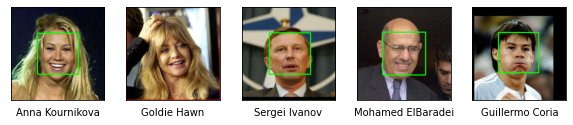

In [14]:
#First 5 images of trainingDf are being drawn by framing detected faces
#Green: Single Face Detected
#Yellow: Multiple Face Detected
#Red: No Face Detected
DrawFaceFrame(trainingDf.head(), result, personDf)

In [15]:
#Faces are being extracted from all images of trainingDf
result = ExtractFace(trainingDf, result)

#Number of face images returned
len(result[0])

4156

In [16]:
#Number of Detection Type returned
len(result[1])

4156

In [17]:
#Face images and detection types are being appended to the trainingDf
trainingDf['ImageBGR'] = result[0]
trainingDf['DetectionType'] = result[1]
trainingDf

,PersonID,ImageBGR,DetectionType
0,22,"[[[71, 116, 99], [69, 116, 98], [67, 115, 98],...",SingleFace
1,125,"[[[29, 43, 55], [29, 43, 55], [28, 42, 54], [2...",NoFace
2,356,"[[[177, 199, 204], [176, 199, 204], [175, 200,...",SingleFace
3,277,"[[[91, 103, 121], [91, 104, 122], [92, 105, 12...",SingleFace
4,131,"[[[42, 65, 81], [38, 61, 77], [30, 53, 68], [2...",SingleFace
...,...,...,...
4151,4,"[[[64, 89, 93], [62, 88, 92], [60, 86, 90], [5...",SingleFace
4152,120,"[[[114, 93, 71], [116, 96, 74], [122, 101, 79]...",SingleFace
4153,322,"[[[193, 202, 211], [193, 202, 211], [193, 205,...",NoFace
4154,383,"[[[7, 5, 5], [7, 5, 5], [8, 5, 5], [8, 6, 6], ...",SingleFace


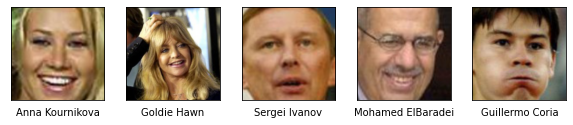

In [18]:
#First 5 face images of trainingDf are being drawn
DrawImage(trainingDf.head(), personDf)

In [19]:
#Shape of the first image of the trainingDf is being checked
trainingDf.iloc[0].ImageBGR.shape

(224, 224, 3)

In [20]:
#Selected validation data is being read from md5 file
validationDf = pd.read_pickle("../Data/RawData/Selected/Validation.pkl")
validationDf

,PersonID,ImageBGR
0,171,"[[[28, 8, 3], [28, 8, 3], [28, 8, 3], [28, 8, ..."
1,120,"[[[13, 20, 15], [13, 20, 15], [13, 20, 15], [1..."
2,196,"[[[60, 67, 60], [60, 67, 60], [60, 67, 60], [5..."
3,95,"[[[94, 131, 175], [98, 135, 179], [99, 136, 18..."
4,380,"[[[84, 37, 15], [83, 36, 14], [83, 36, 14], [8..."
...,...,...
909,71,"[[[2, 0, 0], [0, 0, 0], [1, 1, 1], [0, 0, 0], ..."
910,183,"[[[58, 34, 22], [54, 29, 19], [45, 23, 12], [4..."
911,120,"[[[4, 0, 0], [2, 0, 0], [2, 0, 0], [2, 0, 0], ..."
912,120,"[[[27, 51, 71], [26, 50, 70], [26, 50, 68], [2..."


In [21]:
#Shape of the first image of the validationDf is being checked
validationDf.iloc[0].ImageBGR.shape

(250, 250, 3)

In [22]:
#Faces in all images of validationDf are being detected
result = FaceDetection(faceCascade, validationDf.ImageBGR)

#result[0] is being printed
result[0]

{'SingleFace': 831, 'NoFace': 8, 'MultipleFace': 75, 'totalImage': 914}

In [23]:
#Number of Face Location returned
len(result[1])

914

In [24]:
#Number of Detection Type returned
len(result[2])

914

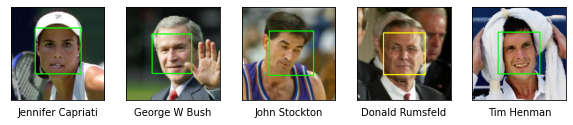

In [25]:
#First 5 images of validationDf are being drawn by framing detected faces
#Green: Single Face Detected
#Yellow: Multiple Face Detected
#Red: No Face Detected
DrawFaceFrame(validationDf.head(), result, personDf)

In [26]:
#Faces are being extracted from all images of validationDf
result = ExtractFace(validationDf, result)

#Number of face images returned
len(result[0])

914

In [27]:
#Number of Detection Type returned
len(result[1])

914

In [28]:
#Face images and detection types are being appended to the validationDf
validationDf['ImageBGR'] = result[0]
validationDf['DetectionType'] = result[1]
validationDf

,PersonID,ImageBGR,DetectionType
0,171,"[[[64, 65, 56], [93, 94, 85], [143, 144, 135],...",SingleFace
1,120,"[[[102, 116, 110], [106, 120, 114], [115, 129,...",SingleFace
2,196,"[[[23, 40, 43], [23, 40, 43], [24, 41, 44], [2...",SingleFace
3,95,"[[[34, 55, 63], [35, 56, 65], [38, 59, 69], [4...",MultipleFace
4,380,"[[[227, 227, 227], [227, 227, 227], [227, 227,...",SingleFace
...,...,...,...
909,71,"[[[104, 116, 120], [103, 116, 121], [102, 117,...",SingleFace
910,183,"[[[35, 17, 10], [35, 17, 11], [36, 17, 12], [3...",SingleFace
911,120,"[[[109, 141, 160], [105, 137, 156], [97, 129, ...",SingleFace
912,120,"[[[84, 94, 111], [81, 91, 108], [76, 86, 103],...",SingleFace


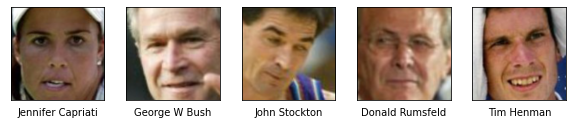

In [29]:
#First 5 face images of validationDf are being drawn
DrawImage(validationDf.head(), personDf)

In [30]:
#Shape of the first image of the validationDf is being checked
validationDf.iloc[0].ImageBGR.shape

(224, 224, 3)

In [31]:
#Selected test data is being read from md5 file
testDf = pd.read_pickle("../Data/RawData/Selected/Test.pkl")
testDf

,PersonID,ImageBGR
0,270,"[[[0, 0, 3], [0, 0, 3], [0, 0, 3], [0, 0, 3], ..."
1,80,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,14,"[[[100, 142, 119], [100, 142, 119], [100, 142,..."
3,120,"[[[166, 148, 131], [168, 148, 131], [162, 140,..."
4,401,"[[[9, 0, 0], [9, 0, 0], [9, 0, 0], [9, 0, 0], ..."
...,...,...
910,291,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
911,302,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
912,401,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
913,340,"[[[9, 32, 77], [9, 32, 77], [9, 32, 77], [10, ..."


In [32]:
#Shape of the first image of the testDf is being checked
testDf.iloc[0].ImageBGR.shape

(250, 250, 3)

In [33]:
#Faces in all images of testDf are being detected
result = FaceDetection(faceCascade, testDf.ImageBGR)

#result[0] is being printed
result[0]

{'SingleFace': 828, 'NoFace': 9, 'MultipleFace': 78, 'totalImage': 915}

In [34]:
#Number of Face Location returned
len(result[1])

915

In [35]:
#Number of Detection Type returned
len(result[2])

915

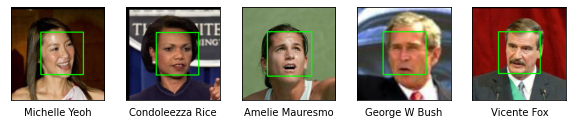

In [36]:
#First 5 images of testDf are being drawn by framing detected faces
#Green: Single Face Detected
#Yellow: Multiple Face Detected
#Red: No Face Detected
DrawFaceFrame(testDf.head(), result, personDf)

In [37]:
#Faces are being extracted from all images of testDf
result = ExtractFace(testDf, result)

#Number of face images returned
len(result[0])

915

In [38]:
#Number of Detection Type returned
len(result[1])

915

In [39]:
#Face images and detection types are being appended to the testDf
testDf['ImageBGR'] = result[0]
testDf['DetectionType'] = result[1]
testDf

,PersonID,ImageBGR,DetectionType
0,270,"[[[0, 2, 13], [0, 1, 11], [0, 0, 8], [0, 0, 7]...",SingleFace
1,80,"[[[9, 11, 22], [9, 11, 23], [10, 12, 25], [11,...",SingleFace
2,14,"[[[43, 69, 53], [32, 58, 42], [13, 37, 22], [6...",SingleFace
3,120,"[[[161, 124, 104], [160, 124, 105], [159, 125,...",SingleFace
4,401,"[[[8, 15, 142], [7, 15, 142], [6, 15, 142], [6...",SingleFace
...,...,...,...
910,291,"[[[157, 175, 176], [152, 170, 173], [143, 161,...",SingleFace
911,302,"[[[76, 82, 89], [76, 82, 89], [77, 82, 90], [7...",MultipleFace
912,401,"[[[39, 42, 46], [38, 41, 45], [37, 40, 44], [3...",SingleFace
913,340,"[[[11, 16, 25], [11, 16, 24], [12, 15, 23], [1...",SingleFace


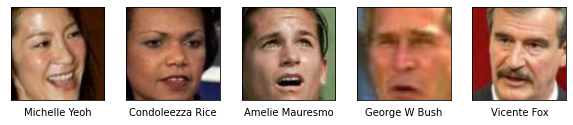

In [40]:
#First 5 face images of testDf are being drawn
DrawImage(testDf.head(), personDf)

In [41]:
#Shape of the first image of the testDf is being checked
testDf.iloc[0].ImageBGR.shape

(224, 224, 3)

In [42]:
#Reorganized data is being saved as pkl file for future use
trainingDf.to_pickle("../Data/ResizedData/FaceOnly/Training.pkl")
validationDf.to_pickle("../Data/ResizedData/FaceOnly/Validation.pkl")
testDf.to_pickle("../Data/ResizedData/FaceOnly/Test.pkl")